# Memory-based collaborative filtering
Dans ce deuxième notebook, nous voulons prédire les ratings non-observés en utilisant une approche "memory-based".
Nous diviserons la base de données en deux, effectuerons l'apprentissage du modèle le train, et vérifierons la pertinence de nos prédictions sur le test.
<br>
<font color="red">
- Effectuer le imports nécessaires  
- Charger la base de donnée MovieLens en précisant les bons noms de colonne  
- Définir les variables n_users et n_items
</font>

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movie_titles = pd.read_csv("Movie_Id_Titles")
n_user =
n_item =

<font color="red">
- Créer la dataframe des interactions avec pivot_table  
- Remplacer tous les NaN par des zéros avec la méthode fillna(0)  
- Extraire les valeurs sous forme de numpy.array
</font>

In [3]:
ratings = 
ratings[:5,:5]

array([[5., 3., 4., 3., 3.],
       [4., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0.]])

<font color="red">
Combien y a-t-il d'éléments non-nuls ? Evaluer le pourcentage d'éléments non-nuls dans cette matrice.  
</font>

### User-based collaborative filtering
Nous calculons une matrice de similarité $S=(S_{i,j})$ entre utilisateurs.
Nous considérons la 'centered cosine similarity' : 
$$
S_{i,j} = \frac{\langle \bar r_i,\bar r_j\rangle}{\|\bar r_i\|\,\|\bar r_j\|}
$$
où $\bar r_i$ est le vecteur des ratings de l'utilisateur $i$, recentré par la moyenne des notes qu'a données l'utilisateur en question. La fonction suivante fournit la matrice de similarité.

In [5]:
def similarity(ratings):
    
    # vecteur contenant pour chaque utilisateur le nombre de notes données
    r_user = (ratings>0).sum(axis=1)  
    
    # vecteur contenant pour chaque utilisateur la moyenne des notes données
    m_user = np.divide(ratings.sum(axis=1) , r_user, where=r_user!=0)
    
    # Notes recentrées par la moyenne par utilisateur : chaque ligne i contient le vecteur \bar r_i
    ratings_ctr = ratings.T - ((ratings.T!=0) * m_user)
    ratings_ctr = ratings_ctr.T

    # Matrice de Gram, contenant les produits scalaires
    sim = ratings_ctr.dot(ratings_ctr.T)
    
    # Renormalisation
    norms = np.array([np.sqrt(np.diagonal(sim))])
    sim = sim / norms / norms.T  
    # (En numpy, diviser une matrice par un vecteur ligne (resp. colonne) 
    # revient à diviser chaque ligne (resp. colonne) terme à terme par les éléments du vecteur)
    
    return sim

### Prédiction
On souhaite prédire toutes les notes d'un utilisateur $u$, à partir des notes données par les utilisateurs qui lui sont similaires.

Une première approche consiste, pour tout item $i$, à définir
$$
\hat r_{u,i} = \frac{\sum_{v} \varphi(S_{u,v}) r_{v,i}}{\sum_{v:r_{v,i}\neq 0} \varphi(S_{u,v})}
$$
où $\varphi(\,.\,)$ est une fonction à valeurs positives, et 
où la somme est restreinte aux utilisateurs $v$ ayant effectivement noté l'item i, soit :
$$
\hat r_{u,i} = \frac{\sum_{v} \varphi(S_{u,v}) r_{v,i}}{\sum_{v}\varphi(S_{u,v})1_{r_{v,i}>0}}
$$
Remarque : Le numérateur est la composante $(u,i)$ de la matrice $\phi(S)R$. Le dénominateur est la composante $(u,i)$ de la matrice $\phi(S) (R>0)$. On obtient donc la matrice $\hat R$ en divisant terme à terme ces deux matrices.
<br>
<font color="red">
Définir une fonction $\phi(x)$ retournant le maximum de $x$ et de 0.</font>

In [6]:
def phi(x):
    return

<font color="red">
Former la matrice $\phi(S)*R$, la matrice $\phi(S)*(R>0)$ et diviser terme à terme ces deux matrices   
(Remarque : on pourra utiliser np.divide(numerator,denominator,where = denominator!=0) pour éviter le warning causé par une division par 0).
</font>

In [ ]:
sim = 
numerator = 
denominator = 
pred_ratings = np.divide(numerator,denominator,where = denominator!=0)

<font color="red">
Afficher les prédictions du premier utilisateur pour les dix premiers items.</font>

Nous pouvons évaluer l'erreur. La métrique classiquement utilisée est le RMSE :
$$
RMSE = \sqrt{\frac 1N\sum_{(u,i)\text{ observés}}(R_{u,i}-\hat R_{u,i})^2}\,.
$$
où $N$ est le nombre de ratings observés.  
<font color="red">
Calculer le RMSE.</font>

In [9]:
RMSE = np.sqrt(np.sum(((ratings - pred_ratings) * (ratings>0))**2) / np.sum(ratings>0))
RMSE

0.7489066993195281

### Validation
Afin d'évaluer la performance de la méthode, nous devons diviser les données en un train et un test set, apprendre sur le train, et évaluer le RMSE sur le test.

Pour chaque utilisateur, on place 10 ratings dans la base de test.  

In [11]:
from scipy.sparse import *
import random as rd

def train_test_split(df,ratioTraining=0.9):
    
    n_user = df['user_id'].nunique()
    n_item = df['item_id'].nunique()
    n_ratings = df.shape[0]
    
    train_idx = np.sort(rd.sample(range(n_ratings),int(np.floor(ratioTraining*n_ratings))))
    test_idx = np.setxor1d(range(n_ratings),train_idx)
    
    train = coo_matrix((df.iloc[train_idx]['rating'].values,
                        (df.iloc[train_idx]['user_id'].values-1,
                         df.iloc[train_idx]['item_id'].values-1)),
                       shape=(n_user,n_item)).toarray()
    
    test = coo_matrix((df.iloc[test_idx]['rating'].values,
                        (df.iloc[test_idx]['user_id'].values-1,
                         df.iloc[test_idx]['item_id'].values-1)),
                       shape=(n_user,n_item)).toarray() 
    
    print('Training : %.d exemples, Test : %d exemples' 
          % (train.nonzero()[0].shape[0],test.nonzero()[0].shape[0]))
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [12]:
train, test = train_test_split(df,0.9)

Training : 90000 exemples, Test : 10000 exemples


Nous définissons les fonctions nécessaires à la prédiction et l'évaluation

In [13]:
def predict_ratings(ratings,sim,phi=(lambda x:x)):
    
    wsum_sim = np.abs(phi(sim)).dot(ratings>0)
    return np.divide(phi(sim).dot(ratings) , wsum_sim, where= wsum_sim!=0)

def rmse(ratings,pred):
    return np.sqrt(np.sum(((ratings - pred) * (ratings>0))**2) / np.sum(ratings>0))

<font color="red">
- Avec similarity(), évaluer la matrice de similarité sur le train set.  
- Effectuer la prédiction des ratings
- Calculer le RMSE sur le test set.
</font>

In [ ]:
# Calcul de la similarité sur le train
sim = 
# Prédictions
pred_ratings = 
# Performance
rmse( ... )

### Comparaison
<font color="red">
Avec train.sum(axis=1), on peut créer sommer la matrice 'train' le long des lignes. Créer le vecteur des notes moyennes des utilisateurs. Evaluer le RMSE lorsqu'on prédit que chaque utilisateur donne une note toujours égale à sa moyenne.</font>

In [15]:
av_ratings = ...
rmse(test,av_ratings.reshape(train.shape[0],1))

1.0337334823341828

### Bias-subtracted Collaborative Filtering
Certains utilisateurs sont susceptibles de donner des notes toujours assez hautes, ou toujours assez basses. Il y a donc un biais, relatif à cet uilisateur. On peut imaginer que la différence relative des notes est plus importante que leur valeur absolue.

Nous allons donc soustraire la moyenne des notes de chaque utilisateur avant de sommer sur tous les utilisateurs similaires, puis nous réajouterons la moyenne soustraite à la fin :
$$
\hat r_{u,i} = \bar r_u + \frac{\sum_{v} \varphi(S_{u,v}) (r_{v,i}- \bar r_v)}{\sum_{v}\varphi(S_{u,v})1_{r_{v,i}>0}}
$$
où $\bar r_u$ est la note moyenne de l'utilisateur $u$.
<br>
<font color="red">
Observer la différence entre la fonction predict_ratings_bias_sub ci-dessous et la fonction predict_ratings précédente.
</font>

In [16]:
def predict_ratings_bias_sub(ratings,sim,phi=(lambda x:x)):

    r_user = (ratings>0).sum(axis=1)
    m_user = np.divide(ratings.sum(axis=1) , r_user, where=(r_user!=0))
    ratings_moyens = np.dot(m_user.reshape(len(m_user),1), np.ones((1,ratings.shape[1])))
   
    wsum_sim = np.abs(phi(sim)).dot(ratings>0)
    pred = ratings_moyens + np.divide(phi(sim).dot(ratings-(ratings>0)*ratings_moyens),wsum_sim, where= wsum_sim!=0)
    
    return np.minimum(5,np.maximum(1,pred))

<font color="red">
Evaluer les performances de cette nouvelle méthode.</font>

### Recommander des films à un utilisateur

<font color="red">
- Extraire le vecteur des prédiction d'un utilisateur au choix (disons le premier).  
- Avec np.argsort et np.flip, créer un vecteur comportant les items_id par ordre décroissant de prédiction.  
- Afficher les titres de film les plus pertinents, en utilisant la dataframe movie_titles.
</font>

In [29]:
user_id = 0
best_items = np.flip(np.argsort( ... ),axis=0)
movie_titles.set_index('item_id').loc[best_items+1].head(10)

,title
item_id,
851,Two or Three Things I Know About Her (1966)
1500,Santa with Muscles (1996)
1467,"Saint of Fort Washington, The (1993)"
1536,Aiqing wansui (1994)
1449,Pather Panchali (1955)
814,"Great Day in Harlem, A (1994)"
119,Maya Lin: A Strong Clear Vision (1994)
1642,Some Mother's Son (1996)
1367,Faust (1994)


Comme précédemment, on peut se restreindre aux films ayant plus de 100 notes.  On créée une fonction de recommandation permettant de faire cela.

In [30]:
def reco_movie(user_id,ratings):
    df_rec = movie_titles.join(df.groupby('item_id').count()['rating'],on='item_id')
    order = np.flip(np.argsort(ratings[user_id]),axis=0)
    ranks = np.argsort(order)+1
    df_rec['rank'] = pd.Series(ranks)
    df_rec.sort_values(by='rank',inplace=True)
    return pd.DataFrame(df_rec[df_rec['rating']>100]['title']).head(10)

In [31]:
reco_movie(0,pred_ratings)

,title
168,"Wrong Trousers, The (1993)"
407,"Close Shave, A (1995)"
49,Star Wars (1977)
63,"Shawshank Redemption, The (1994)"
11,"Usual Suspects, The (1995)"
126,"Godfather, The (1972)"
222,Sling Blade (1996)
482,Casablanca (1942)
173,Raiders of the Lost Ark (1981)
317,Schindler's List (1993)


In [32]:
def reco_movie(user_id,ratings):
    df_rec = movie_titles.join(df.groupby('item_id').count()['rating'],on='item_id')
    order = np.flip(np.argsort(ratings[user_id-1]),axis=0)
    ranks = np.argsort(order)+1
    df_rec['rank'] = pd.Series(ranks)
    df_rec.sort_values(by='rank',inplace=True)
    return pd.DataFrame(df_rec[df_rec['rating']>100]['title']).head(10)
    

<font color="red">Tester la fonction de recommandation, pour un ou deux utilisateurs arbitrairement choisis.</font>

### Alternating Least Square
On cherche à résoudre le problème d'optimisation suivant :
$$
\min_{P,Q} \sum_{(u,i)\,\text{observés}} (R_{u,i}- (PQ)_{u,i})^2 + \lambda \|P\|^2_F+ \lambda \|Q\|^2_F
$$
où  
- $P$ est une matrice $n_{\text{user}}\times K$,  
- $Q$ est une matrice $K\times n_{\text{item}}$,  
- $K$ est un entier, $\lambda>0$ est un paramètre de régularisation,
- $\|\,.\,|_F$ représente la norme de Froebenius (la racine de la somme des carrés de ses coefficients).  

Le problème d'optimisation est non-convexe. La méthode alternée des moindres carrés (ALS) permet d'obtenir un minimum local du critère ci-dessus. Son fonctionnement est le suivant.  

A chaque itération $t$, on dispose d'une estimée $(P_t,Q_t)$ de la solution. On résoud successivement les sous-problèmes suivants :  
\begin{align}
& P_{t+1} = \arg\min_{P} \sum_{(u,i)\,\text{observés}} (R_{u,i}- (PQ_t)_{u,i})^2 + \lambda \|P\|^2_F \\
& Q_{t+1} = \arg\min_{Q} \sum_{(u,i)\,\text{observés}} (R_{u,i}- (P_{t+1}Q)_{u,i})^2 + \lambda \|Q\|^2_F
\end{align}
Ces deux problèmes sont quadratiques et convexes et peuvent être facilement résolu (par exemple, à l'aide d'un algorithme du gradient conjugué). L'algorithme converge vers un minimum local de la fonction objective décrite au début de ce paragraphe.  

La méthode ALS est implémentée dans le module ML de Spark. Commençons par créer une session Spark.

In [35]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

La fonction suivante permet de convertir une matrice d'interactions dans un format pandas dataframe.
<font color="red">
Visualiser le contenu de la dataframe train_df ci-dessous en affichant ses premières lignes.
</font>

In [18]:
def convert_to_df(ratings,name='rating'):
    R = coo_matrix(ratings)
    arr = np.array([R.row.astype('int'),R.col.astype('int'),R.data]).T
    df = pd.DataFrame(arr,columns=['user_id','item_id',name])
    df['user_id'] = df['user_id'].astype('int')
    df['item_id'] = df['item_id'].astype('int')
    return df

In [ ]:
train_df = convert_to_df(train)
test_df = convert_to_df(test)

<font color="red">Avec spark.createDataFrame, convertir ces deux dataframe-pandas en dataframe-spark.</font>

In [131]:
train_df = spark.createDataFrame( ... )
test_df = 

<font color="red">Afficher la première ligne de train_df. Quels noms portent les colonnes ?</font>

<font color="red">Importer la méthode ALS du module pyspark.ml.recommendation. Puis, définir une méthode ALS, en précisant les paramètres suivants.</font>

In [183]:
from pyspark.ml.recommendation import ALS
als = ALS(maxIter=, regParam=, rank=, userCol=, itemCol=, ratingCol=,coldStartStrategy="drop")

<font color="red">Fitter le modèle aux données d'apprentissage.</font>

In [184]:
model = 

<font color="red">Transformer les données de test.</font>

In [195]:
predictions = 

<font color="red">Quels noms portent les colonnes de la dataframe predictions ?</font>

<font color="red">Evaluer le RMSE.</font>

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol= ..., predictionCol= ...)
evaluator.evaluate(predictions)

<font color="red">Faire varier les paramètres pou

### Visualisation des résidus
On convertit la dataframe Spark predictions en Pandas

In [196]:
predictions = predictions.toPandas()

<font color="red">
Créer la colonne des résidus et afficher son histogramme.</font>

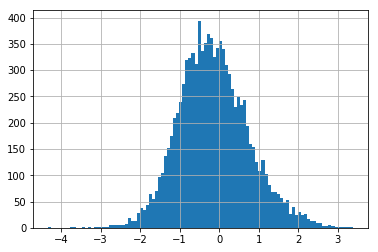

In [197]:
predictions['residual'] =  predictions['prediction']- predictions['rating']
predictions['residual'].hist(bins=100);

Le fait qu'un utilisateur et un item soient représentés dans le train set devrait logiquement avoir un impact sur la variance de ses résidus. On souhaite visualiser cet effet.

<font color="red">
Créer une dataframe ayant pour indice les utilisateurs et pour valeur le nombre de ratings disponibles dans le train set.</font>

In [198]:
r_user = (train>0).sum(axis=1)
count_ratings = pd.DataFrame(r_user,columns=['count_user_ratings'])
count_ratings.index.name = 'user_id'
count_ratings.head()

,count_user_ratings
user_id,
0,245
1,57
2,53
3,20
4,160


<font color="red">
Utiliser la méthode predictions.join(..) pour réunir les deux dataframe le long de la colonne user_id.</font>

In [199]:
predictions = predictions.join(count_ratings,on='user_id')

In [200]:
predictions.head(5)

,user_id,item_id,rating,prediction,residual,count_user_ratings
0,591,148,4,3.938491,-0.061509,323
1,595,148,3,2.448340,-0.551660,16
2,89,148,3,3.828943,0.828943,283
3,326,463,4,2.998777,-1.001223,263
4,344,463,3,3.746337,0.746337,209


On créée de même une colonne correspondant au nombre de ratings de chaque item.

In [201]:
r_item = (train>0).sum(axis=0)
count_ratings = pd.DataFrame(r_item,columns=['count_item_ratings'])
count_ratings.index.name = 'item_id'
predictions = predictions.join(count_ratings,on='item_id')

<font color="red">
Créer dans predictions une colonne correspondant au min des deux colonnes 'count_item_ratings' et 'count_user_ratings'
</font>

In [202]:
predictions['min_count'] = predictions[['count_item_ratings','count_user_ratings']].min(axis=1)

<font color="red">
Afficher les couple (résidu, min nombre de ratings) avec sns.joinplot.</font>

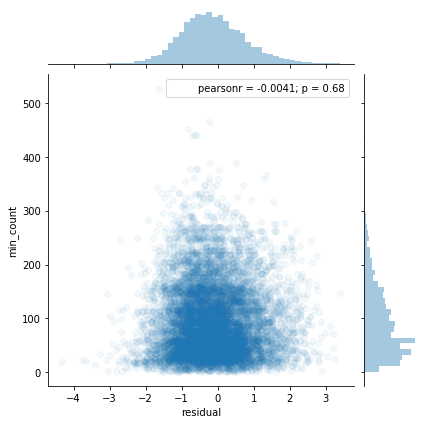

In [203]:
import seaborn as sns
sns.jointplot(x='residual',y='min_count',data=predictions,alpha=0.05);

On a tendance à mieux prédire les notes $r_{u,i}$ lorsque l'utilisateur $u$ et l'item $i$ sont très représentés dans la base de train. Toutefois, même dans ce cas, il reste une dispersion : quelle que soit l'information disponible sur un utilisateur, celui-ci ne peut avoir un comportement parfaitement prédictible. 